In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -500
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 100  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 6 #10
NEGATIVE_REWARD_DIVIDE = 3 # kolikrat bude mensi times factor pri zaporne odmene

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0 #0.6686 # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 0.9993
        
        self.learning_rate = 0.0009441
        self.learning_rate_decay = 0.9999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        """
        model.add(CuDNNLSTM(units=76, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=50, return_sequences=True)) 
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))  
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))
        
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0 #0.00001
    NEGATIVE_TIMES_REWARD = 0 #0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
            
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS 
            if reward < 0:
                reward = reward * (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
                self.closed_counter += reward / (TIMES_FACTOR/NEGATIVE_REWARD_DIVIDE)
            if reward > 0:
                reward = reward * TIMES_FACTOR
                self.closed_counter += reward / TIMES_FACTOR
                
            
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 80 on candle 567


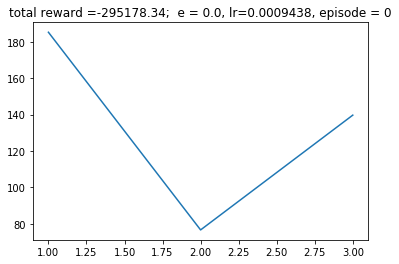

Waiting to train the whole dataset
action0:  511 
action1:  0 
action2:  1439
DONE, lets roll!!
175.534
More than 80 on candle 447
More than 80 on candle 1780


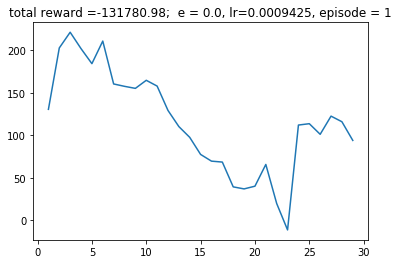

Waiting to train the whole dataset
action0:  274 
action1:  0 
action2:  1676
DONE, lets roll!!
346.249


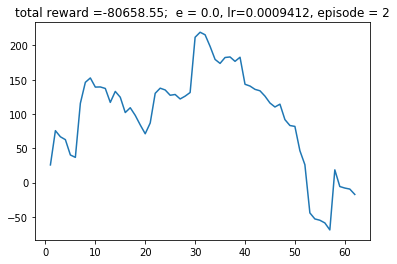

Waiting to train the whole dataset
action0:  158 
action1:  627 
action2:  1165
DONE, lets roll!!
353.498
More than 80 on candle 1865


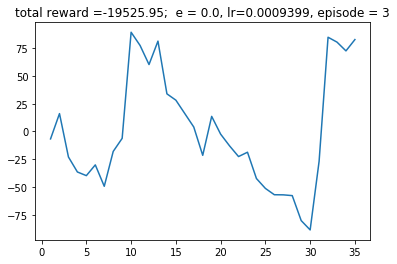

Waiting to train the whole dataset
action0:  0 
action1:  719 
action2:  1231
DONE, lets roll!!
341.924
More than 80 on candle 1744


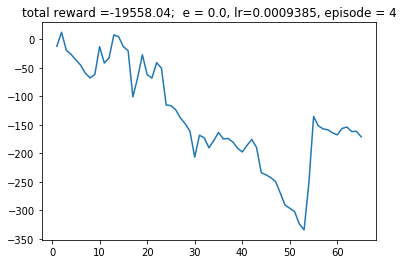

Waiting to train the whole dataset
action0:  5 
action1:  934 
action2:  1011
DONE, lets roll!!
346.891
More than 80 on candle 1744


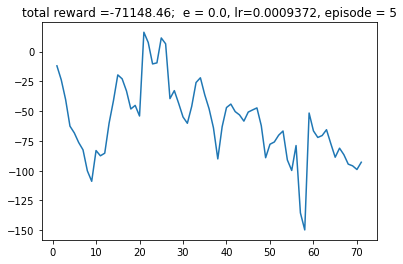

Waiting to train the whole dataset
action0:  141 
action1:  918 
action2:  891
DONE, lets roll!!
344.814
More than 80 on candle 1776


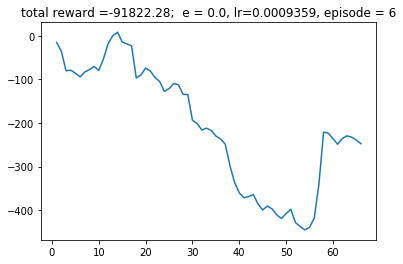

Waiting to train the whole dataset
action0:  186 
action1:  693 
action2:  1071
DONE, lets roll!!
337.92


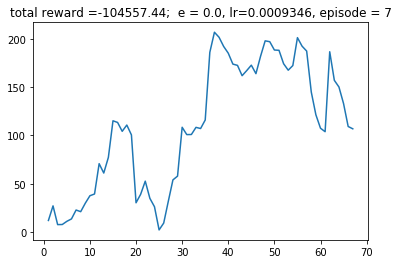

Waiting to train the whole dataset
action0:  215 
action1:  747 
action2:  988
DONE, lets roll!!
342.938
More than 80 on candle 1862


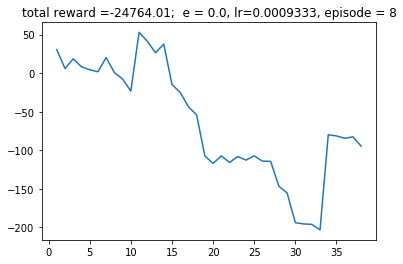

Waiting to train the whole dataset
action0:  10 
action1:  561 
action2:  1379
DONE, lets roll!!
345.264
More than 80 on candle 1739


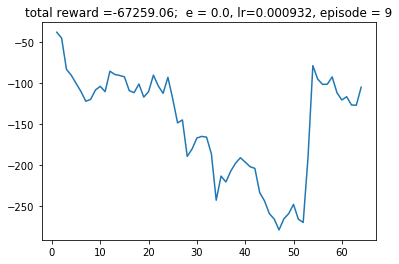

Waiting to train the whole dataset
action0:  127 
action1:  737 
action2:  1086
DONE, lets roll!!
346.054
More than 80 on candle 1796


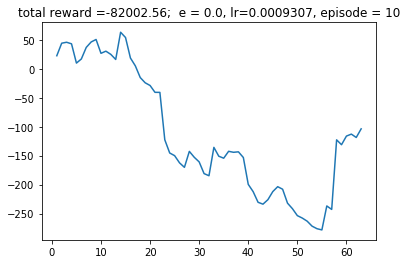

Waiting to train the whole dataset
action0:  162 
action1:  805 
action2:  983
DONE, lets roll!!
349.171
More than 80 on candle 1576
More than 80 on candle 1673


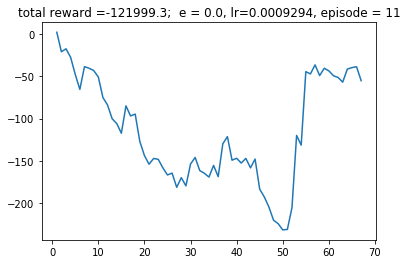

Waiting to train the whole dataset
action0:  257 
action1:  680 
action2:  1013
DONE, lets roll!!
340.315
More than 80 on candle 1787


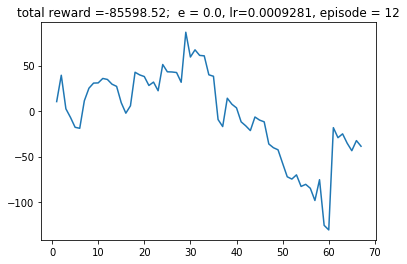

Waiting to train the whole dataset
action0:  173 
action1:  678 
action2:  1099
DONE, lets roll!!
346.133
More than 80 on candle 1764


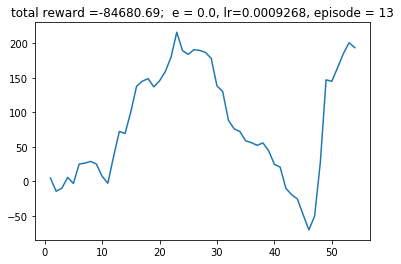

Waiting to train the whole dataset
action0:  174 
action1:  538 
action2:  1238
DONE, lets roll!!
340.511
More than 80 on candle 1786


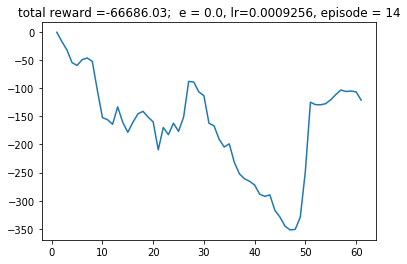

Waiting to train the whole dataset
action0:  133 
action1:  695 
action2:  1122
DONE, lets roll!!
344.371
More than 80 on candle 1746


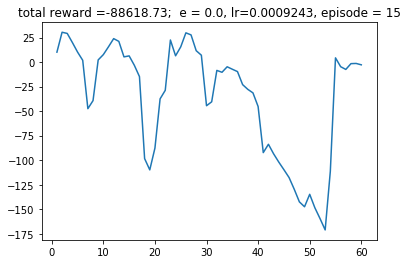

Waiting to train the whole dataset
action0:  182 
action1:  640 
action2:  1128
DONE, lets roll!!
340.252
More than 80 on candle 1744


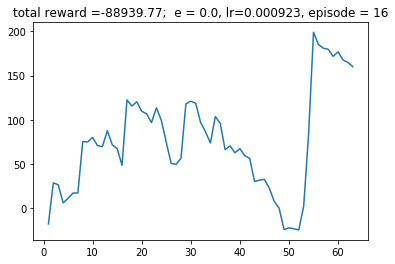

Waiting to train the whole dataset
action0:  185 
action1:  609 
action2:  1156
DONE, lets roll!!
338.179
More than 80 on candle 1775


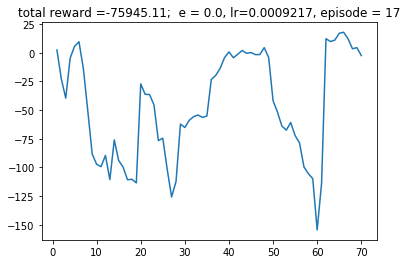

Waiting to train the whole dataset
action0:  153 
action1:  783 
action2:  1014
DONE, lets roll!!
339.335


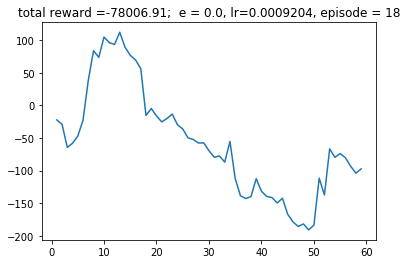

Waiting to train the whole dataset
action0:  145 
action1:  852 
action2:  953
DONE, lets roll!!
342.123
More than 80 on candle 1813


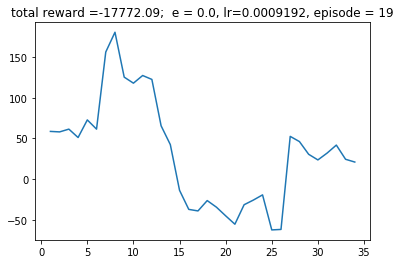

Waiting to train the whole dataset
action0:  0 
action1:  511 
action2:  1439
DONE, lets roll!!
343.152


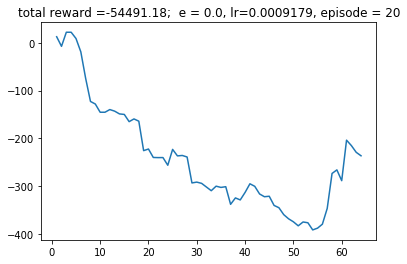

Waiting to train the whole dataset
action0:  89 
action1:  739 
action2:  1122
DONE, lets roll!!
339.656
More than 80 on candle 1853


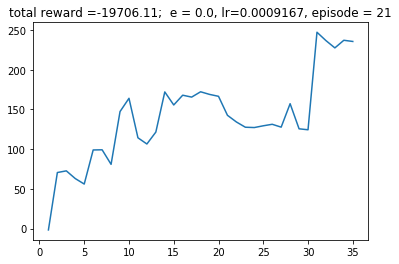

Waiting to train the whole dataset
action0:  8 
action1:  594 
action2:  1348
DONE, lets roll!!
335.688
More than 80 on candle 1776


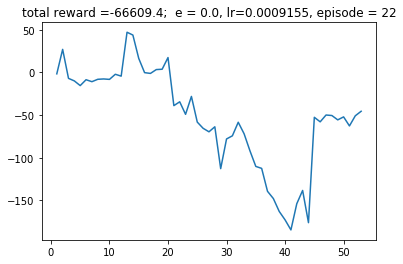

Waiting to train the whole dataset
action0:  131 
action1:  532 
action2:  1287
DONE, lets roll!!
333.161
More than 80 on candle 1728


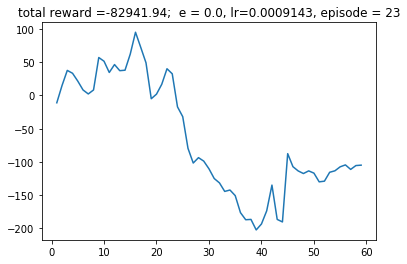

Waiting to train the whole dataset
action0:  164 
action1:  757 
action2:  1029
DONE, lets roll!!
340.279
More than 80 on candle 1774


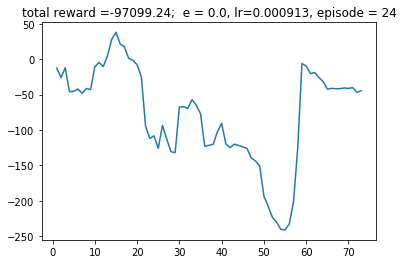

Waiting to train the whole dataset
action0:  200 
action1:  891 
action2:  859
DONE, lets roll!!
346.895
More than 80 on candle 1779


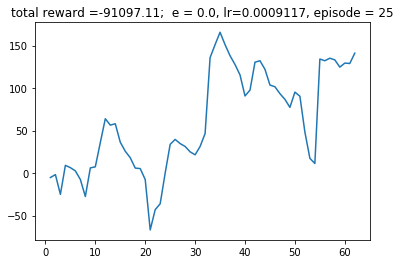

Waiting to train the whole dataset
action0:  195 
action1:  651 
action2:  1104
DONE, lets roll!!
339.217
More than 80 on candle 1798


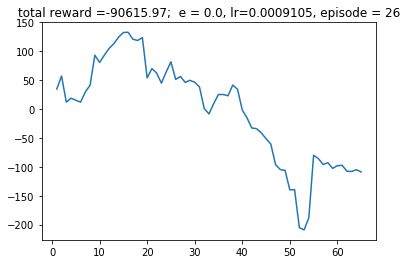

Waiting to train the whole dataset
action0:  176 
action1:  671 
action2:  1103
DONE, lets roll!!
328.921
More than 80 on candle 1770


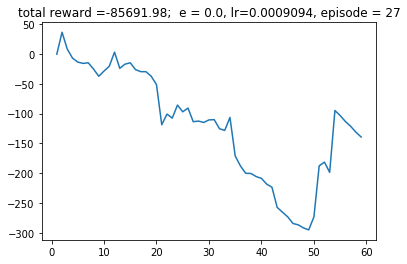

Waiting to train the whole dataset
action0:  173 
action1:  676 
action2:  1101
DONE, lets roll!!
338.742
More than 80 on candle 1781


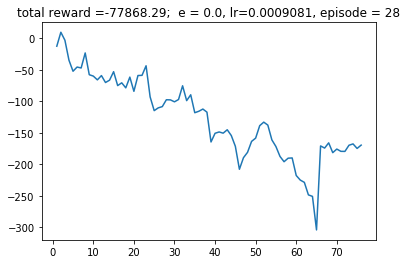

Waiting to train the whole dataset
action0:  152 
action1:  846 
action2:  952
DONE, lets roll!!
343.771
More than 80 on candle 1778


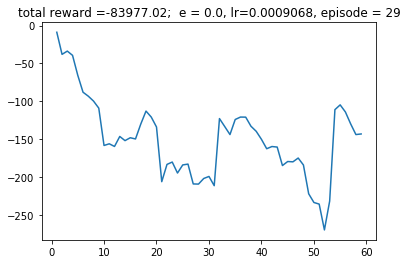

Waiting to train the whole dataset
action0:  170 
action1:  727 
action2:  1053
DONE, lets roll!!
342.347
More than 80 on candle 1773


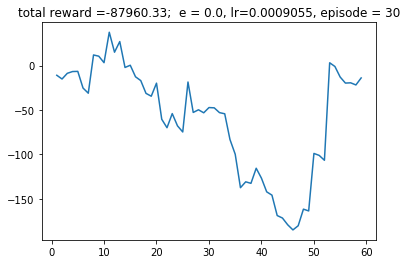

Waiting to train the whole dataset
action0:  174 
action1:  664 
action2:  1112
DONE, lets roll!!
342.687
More than 80 on candle 1797


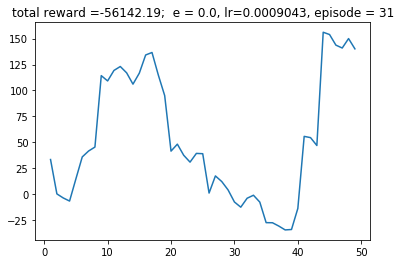

Waiting to train the whole dataset
action0:  104 
action1:  552 
action2:  1294
DONE, lets roll!!
346.65
More than 80 on candle 1745


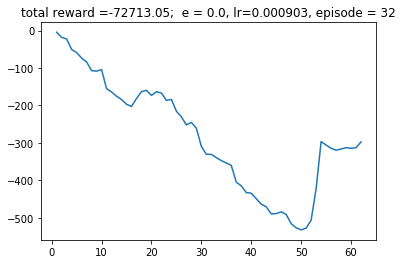

Waiting to train the whole dataset
action0:  137 
action1:  766 
action2:  1047
DONE, lets roll!!
356.684
More than 80 on candle 1769


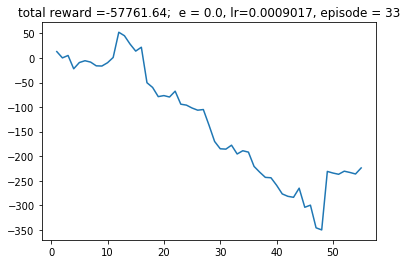

Waiting to train the whole dataset
action0:  100 
action1:  647 
action2:  1203
DONE, lets roll!!
364.846
More than 80 on candle 1769


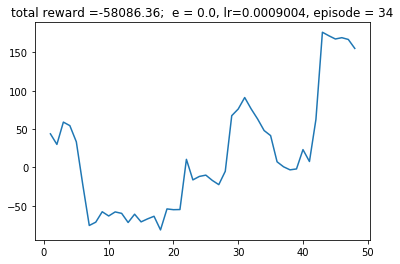

Waiting to train the whole dataset
action0:  117 
action1:  420 
action2:  1413
DONE, lets roll!!
353.692
More than 80 on candle 1765


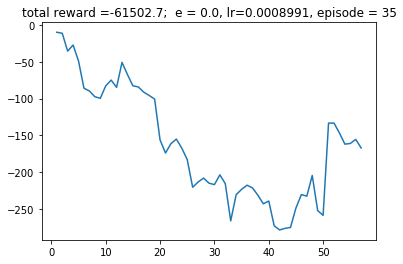

Waiting to train the whole dataset
action0:  112 
action1:  647 
action2:  1191
DONE, lets roll!!
358.548
More than 80 on candle 877
More than 80 on candle 1730


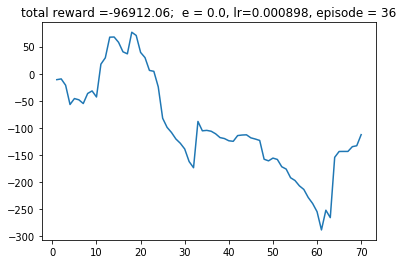

Waiting to train the whole dataset
action0:  199 
action1:  738 
action2:  1013
DONE, lets roll!!
348.675
More than 80 on candle 1791


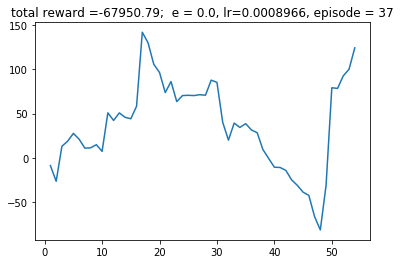

Waiting to train the whole dataset
action0:  132 
action1:  653 
action2:  1165
DONE, lets roll!!
354.277
More than 80 on candle 522
More than 80 on candle 1727


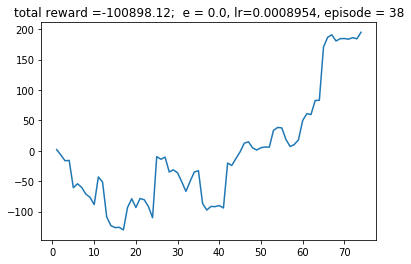

Waiting to train the whole dataset
action0:  215 
action1:  641 
action2:  1094
DONE, lets roll!!
365.405
More than 80 on candle 1791


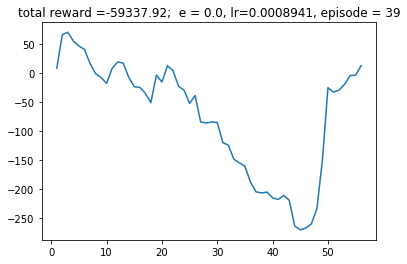

Waiting to train the whole dataset
action0:  112 
action1:  736 
action2:  1102
DONE, lets roll!!
356.919
More than 80 on candle 1576


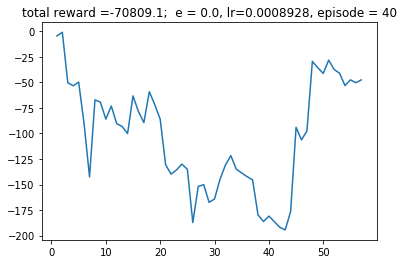

Waiting to train the whole dataset
action0:  140 
action1:  678 
action2:  1132
DONE, lets roll!!
366.151
More than 80 on candle 493
More than 80 on candle 1741


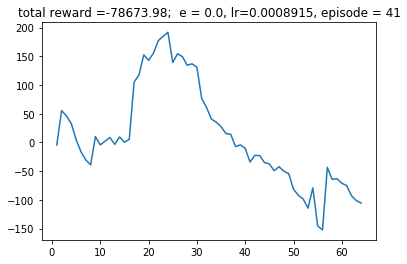

Waiting to train the whole dataset
action0:  159 
action1:  684 
action2:  1107
DONE, lets roll!!
357.659
More than 80 on candle 1789


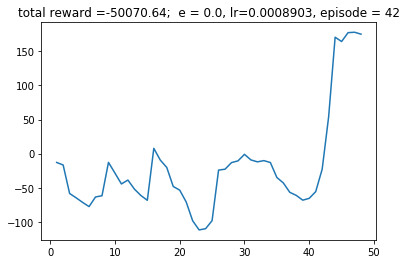

Waiting to train the whole dataset
action0:  91 
action1:  689 
action2:  1170
DONE, lets roll!!
356.878
More than 80 on candle 1775


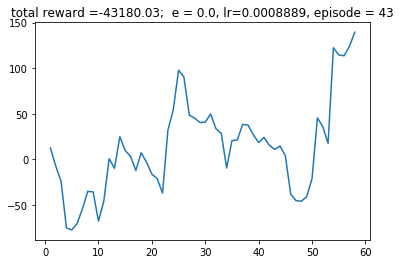

Waiting to train the whole dataset
action0:  72 
action1:  761 
action2:  1117
DONE, lets roll!!
362.088
More than 80 on candle 1781


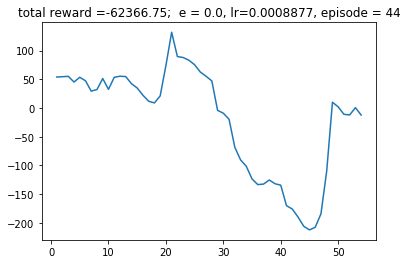

Waiting to train the whole dataset
action0:  117 
action1:  738 
action2:  1095
DONE, lets roll!!
357.677
More than 80 on candle 492
More than 80 on candle 1745


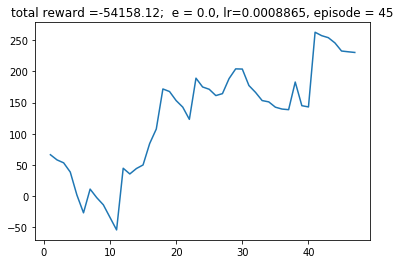

Waiting to train the whole dataset
action0:  109 
action1:  569 
action2:  1272
DONE, lets roll!!
363.84
More than 80 on candle 879
More than 80 on candle 1690


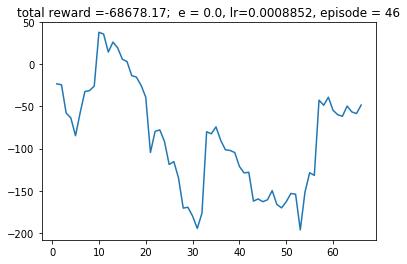

Waiting to train the whole dataset
action0:  134 
action1:  639 
action2:  1177
DONE, lets roll!!
354.537
More than 80 on candle 1791


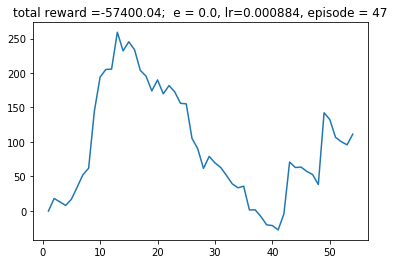

Waiting to train the whole dataset
action0:  110 
action1:  657 
action2:  1183
DONE, lets roll!!
353.013
More than 80 on candle 1770


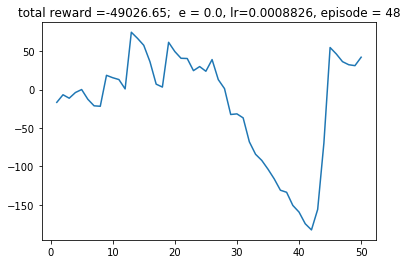

Waiting to train the whole dataset
action0:  89 
action1:  608 
action2:  1253
DONE, lets roll!!
366.967
More than 80 on candle 1790


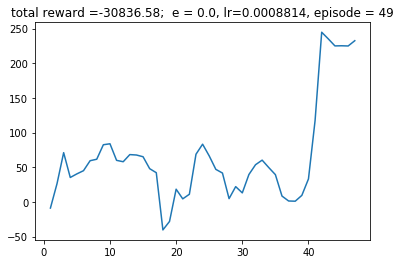

Waiting to train the whole dataset
action0:  54 
action1:  661 
action2:  1235
DONE, lets roll!!
354.616
More than 80 on candle 493
More than 80 on candle 1731


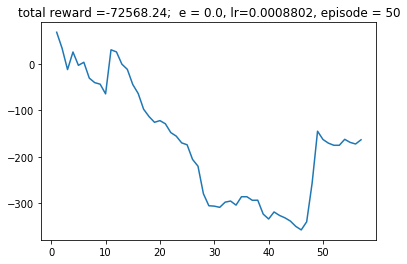

Waiting to train the whole dataset
action0:  145 
action1:  678 
action2:  1127
DONE, lets roll!!
363.14
More than 80 on candle 1772


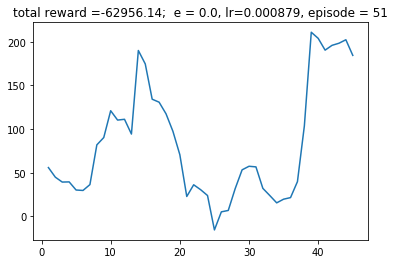

Waiting to train the whole dataset
action0:  123 
action1:  708 
action2:  1119
DONE, lets roll!!
358.328
More than 80 on candle 1770


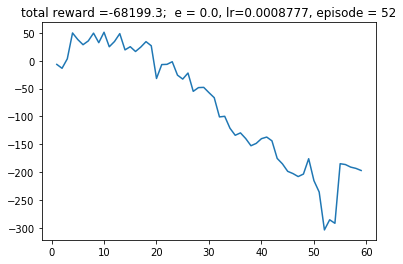

Waiting to train the whole dataset
action0:  134 
action1:  694 
action2:  1122
DONE, lets roll!!
352.969
More than 80 on candle 1774


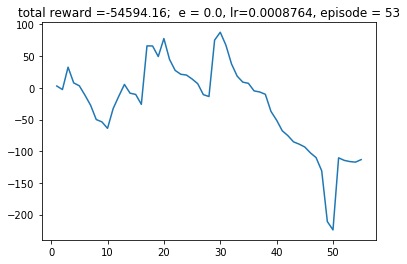

Waiting to train the whole dataset
action0:  99 
action1:  625 
action2:  1226
DONE, lets roll!!
355.701
More than 80 on candle 1813


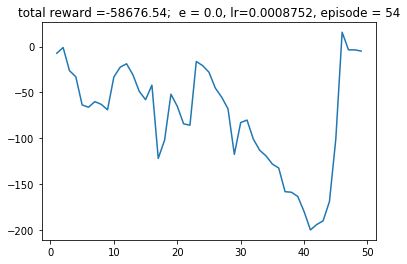

Waiting to train the whole dataset
action0:  111 
action1:  585 
action2:  1254
DONE, lets roll!!
352.028
More than 80 on candle 1796


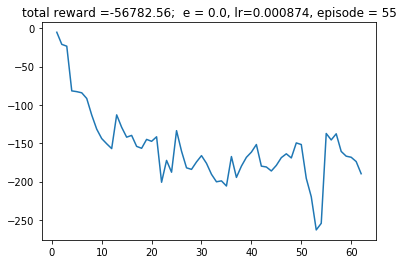

Waiting to train the whole dataset
action0:  106 
action1:  718 
action2:  1126
DONE, lets roll!!
356.68
More than 80 on candle 1765


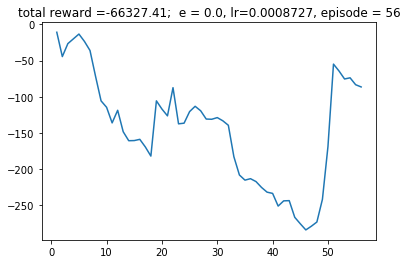

Waiting to train the whole dataset
action0:  127 
action1:  822 
action2:  1001
DONE, lets roll!!
350.81
More than 80 on candle 1779


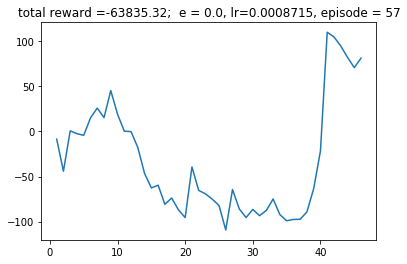

Waiting to train the whole dataset
action0:  122 
action1:  650 
action2:  1178
DONE, lets roll!!
353.362
More than 80 on candle 1768


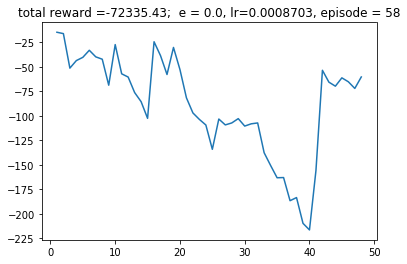

Waiting to train the whole dataset
action0:  139 
action1:  716 
action2:  1095
DONE, lets roll!!
359.227
More than 80 on candle 1802


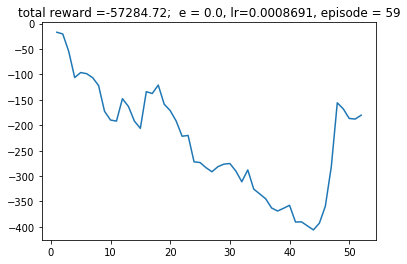

Waiting to train the whole dataset
action0:  101 
action1:  685 
action2:  1164
DONE, lets roll!!
352.444
More than 80 on candle 1745


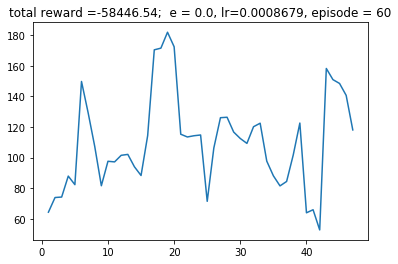

Waiting to train the whole dataset
action0:  108 
action1:  627 
action2:  1215
DONE, lets roll!!
352.115
More than 80 on candle 1772


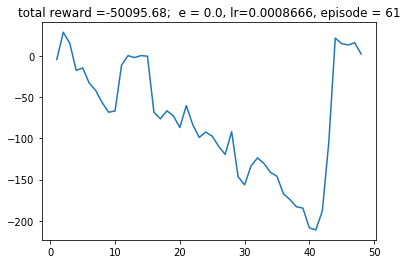

Waiting to train the whole dataset
action0:  88 
action1:  651 
action2:  1211
DONE, lets roll!!
359.946
More than 80 on candle 1784


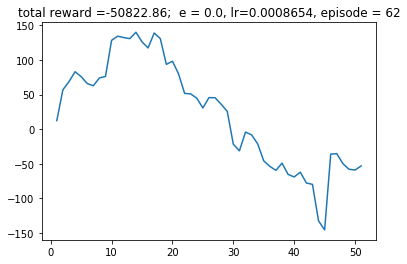

Waiting to train the whole dataset
action0:  94 
action1:  627 
action2:  1229
DONE, lets roll!!
362.767


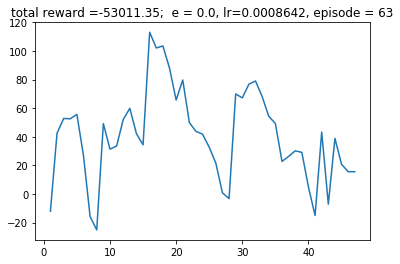

Waiting to train the whole dataset
action0:  88 
action1:  686 
action2:  1176
DONE, lets roll!!
355.473
More than 80 on candle 1858


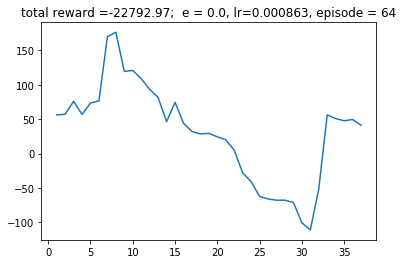

Waiting to train the whole dataset
action0:  16 
action1:  656 
action2:  1278
DONE, lets roll!!
363.396
More than 80 on candle 1785


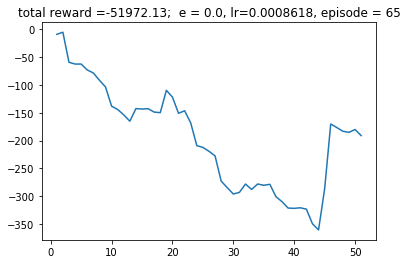

Waiting to train the whole dataset
action0:  86 
action1:  618 
action2:  1246
DONE, lets roll!!
353.339
More than 80 on candle 1791


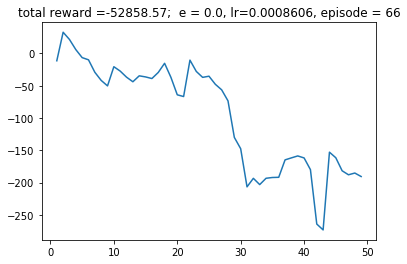

Waiting to train the whole dataset
action0:  89 
action1:  754 
action2:  1107
DONE, lets roll!!
353.263
More than 80 on candle 1792


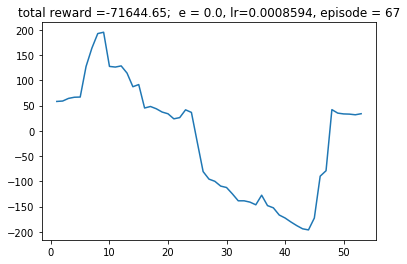

Waiting to train the whole dataset
action0:  138 
action1:  578 
action2:  1234
DONE, lets roll!!
358.714
More than 80 on candle 1737


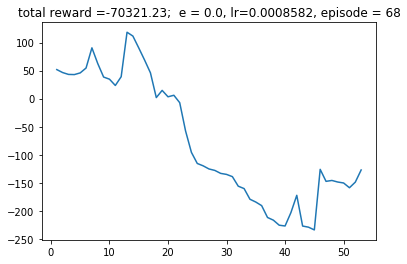

Waiting to train the whole dataset
action0:  130 
action1:  584 
action2:  1236
DONE, lets roll!!
359.085
More than 80 on candle 1787


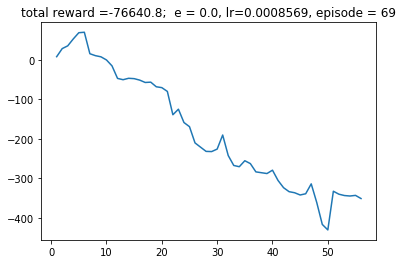

Waiting to train the whole dataset
action0:  140 
action1:  497 
action2:  1313
DONE, lets roll!!
359.927
More than 80 on candle 1742


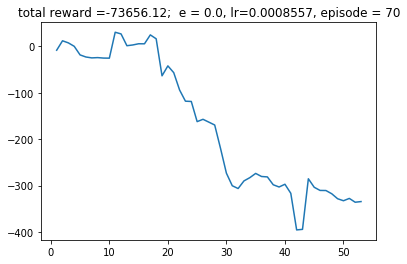

Waiting to train the whole dataset
action0:  130 
action1:  519 
action2:  1301
DONE, lets roll!!
356.65
More than 80 on candle 1774


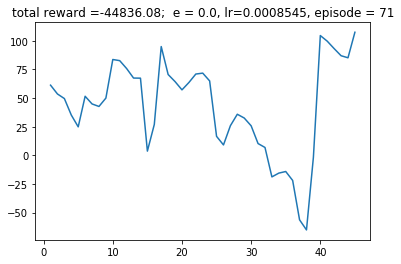

Waiting to train the whole dataset
action0:  81 
action1:  739 
action2:  1130
DONE, lets roll!!
352.947
More than 80 on candle 1806


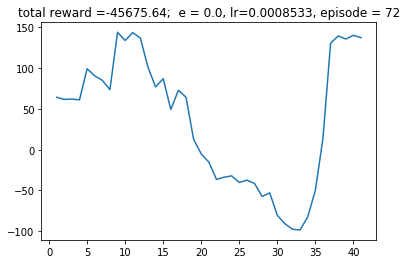

Waiting to train the whole dataset
action0:  82 
action1:  597 
action2:  1271
DONE, lets roll!!
361.546
More than 80 on candle 1560


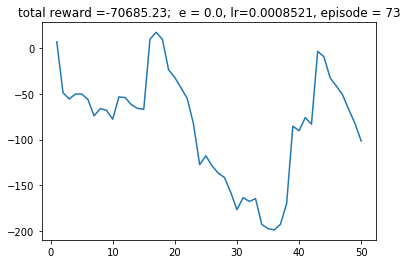

Waiting to train the whole dataset
action0:  134 
action1:  773 
action2:  1043
DONE, lets roll!!
358.013
More than 80 on candle 1803


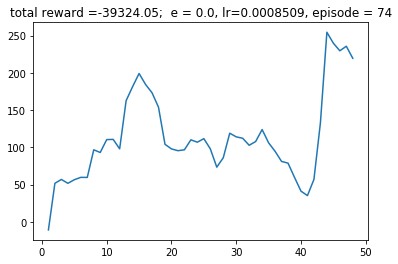

Waiting to train the whole dataset
action0:  73 
action1:  595 
action2:  1282
DONE, lets roll!!
360.445
More than 80 on candle 1790


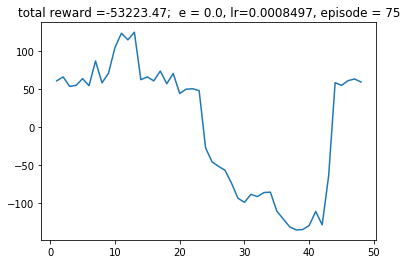

Waiting to train the whole dataset
action0:  93 
action1:  612 
action2:  1245
DONE, lets roll!!
360.034
More than 80 on candle 1800


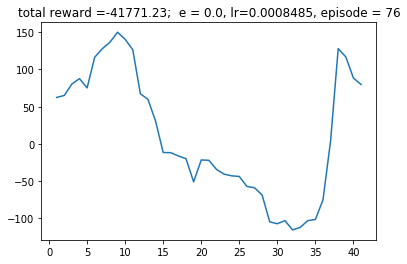

Waiting to train the whole dataset
action0:  68 
action1:  510 
action2:  1372
DONE, lets roll!!
361.541
More than 80 on candle 1781


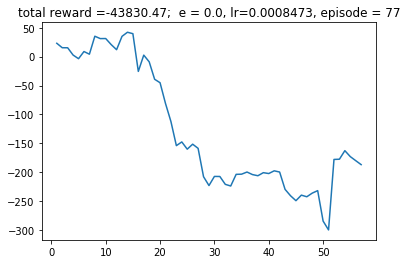

Waiting to train the whole dataset
action0:  69 
action1:  626 
action2:  1255
DONE, lets roll!!
358.253
More than 80 on candle 1802


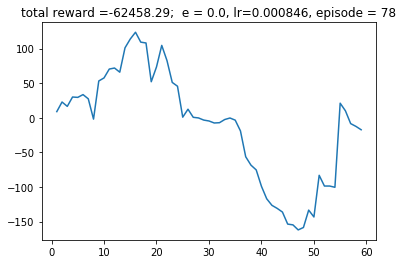

Waiting to train the whole dataset
action0:  112 
action1:  678 
action2:  1160
DONE, lets roll!!
361.985
More than 80 on candle 538
More than 80 on candle 1577


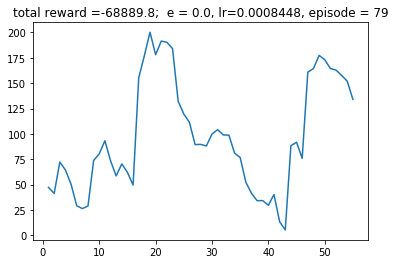

Waiting to train the whole dataset
action0:  142 
action1:  722 
action2:  1086
DONE, lets roll!!
359.96
More than 80 on candle 1776


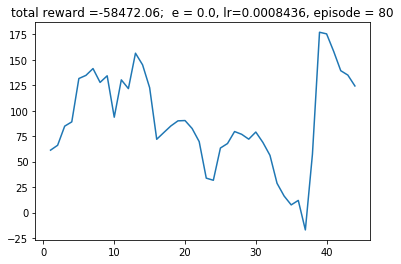

Waiting to train the whole dataset
action0:  110 
action1:  832 
action2:  1008
DONE, lets roll!!
358.366
More than 80 on candle 493


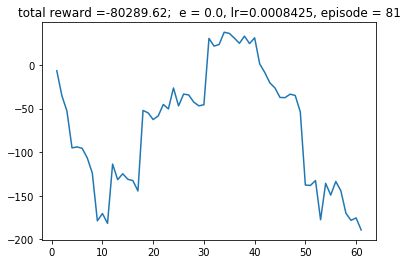

Waiting to train the whole dataset
action0:  151 
action1:  733 
action2:  1066
DONE, lets roll!!
358.432


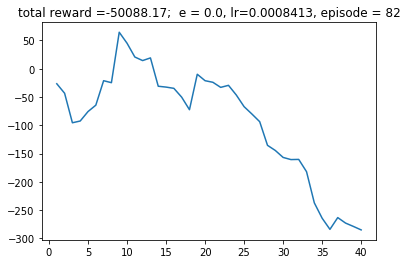

Waiting to train the whole dataset
action0:  55 
action1:  609 
action2:  1286
DONE, lets roll!!
351.349
More than 80 on candle 1872


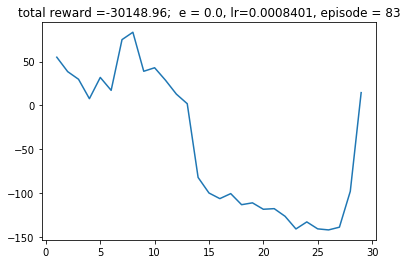

Waiting to train the whole dataset
action0:  18 
action1:  569 
action2:  1363
DONE, lets roll!!
355.263
More than 80 on candle 1786


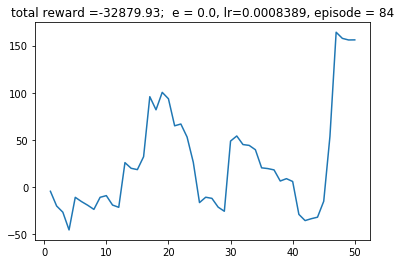

Waiting to train the whole dataset
action0:  48 
action1:  673 
action2:  1229
DONE, lets roll!!
363.144
More than 80 on candle 1808


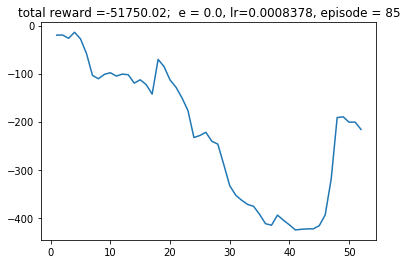

Waiting to train the whole dataset
action0:  88 
action1:  679 
action2:  1183
DONE, lets roll!!
356.973
More than 80 on candle 1772


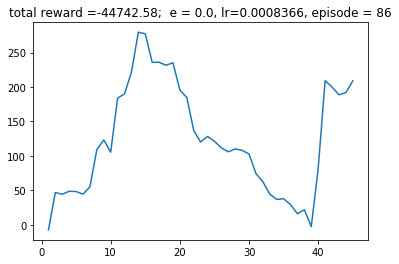

Waiting to train the whole dataset
action0:  82 
action1:  710 
action2:  1158
DONE, lets roll!!
352.144
More than 80 on candle 476
More than 80 on candle 1783


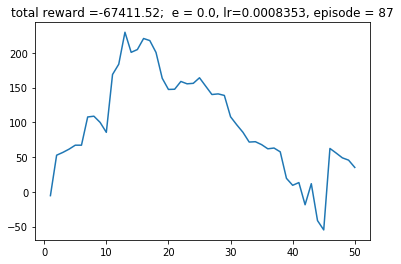

Waiting to train the whole dataset
action0:  129 
action1:  634 
action2:  1187
DONE, lets roll!!
360.937
More than 80 on candle 1812


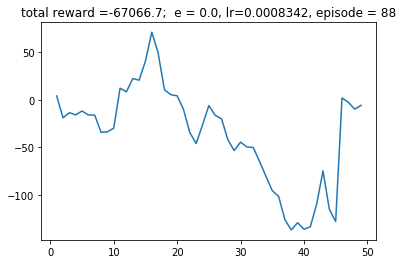

Waiting to train the whole dataset
action0:  130 
action1:  533 
action2:  1287
DONE, lets roll!!
358.814
More than 80 on candle 1836


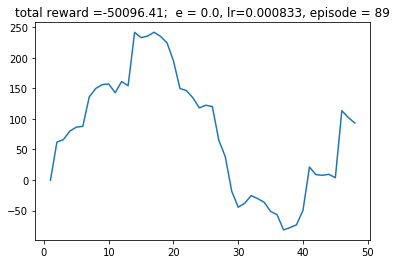

Waiting to train the whole dataset
action0:  92 
action1:  547 
action2:  1311
DONE, lets roll!!
364.177
More than 80 on candle 1788


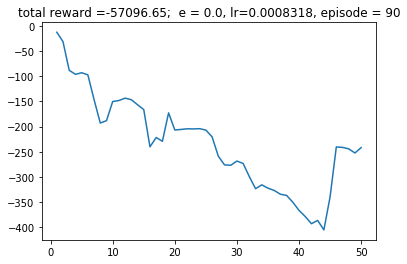

Waiting to train the whole dataset
action0:  103 
action1:  649 
action2:  1198
DONE, lets roll!!
362.438
More than 80 on candle 490
More than 80 on candle 1769


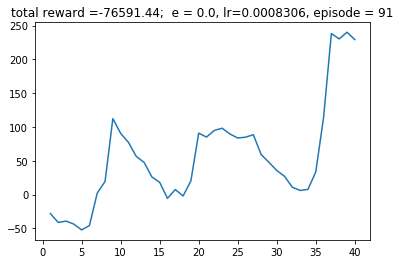

Waiting to train the whole dataset
action0:  158 
action1:  623 
action2:  1169
DONE, lets roll!!
359.104
More than 80 on candle 1842


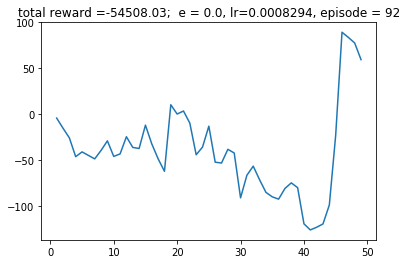

Waiting to train the whole dataset
action0:  95 
action1:  779 
action2:  1076
DONE, lets roll!!
355.556
More than 80 on candle 513
More than 80 on candle 1741


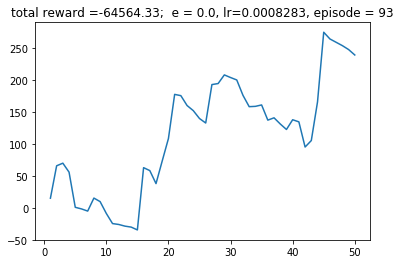

Waiting to train the whole dataset
action0:  129 
action1:  675 
action2:  1146
DONE, lets roll!!
360.833
More than 80 on candle 1578


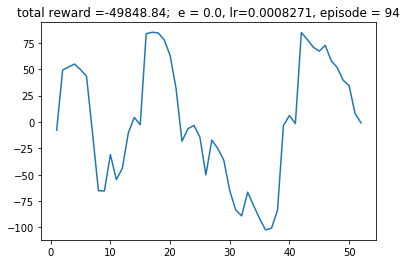

Waiting to train the whole dataset
action0:  80 
action1:  812 
action2:  1058
DONE, lets roll!!
357.959
More than 80 on candle 1792


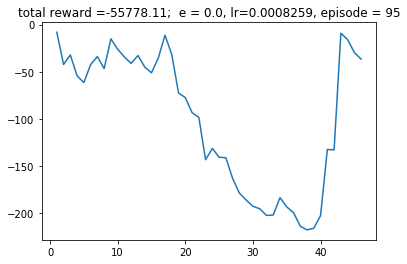

Waiting to train the whole dataset
action0:  94 
action1:  576 
action2:  1280
DONE, lets roll!!
356.916
More than 80 on candle 1785


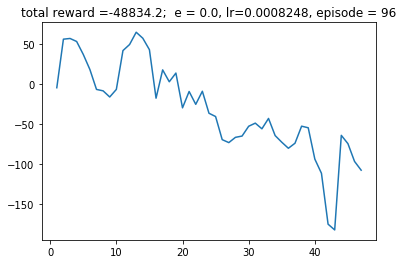

Waiting to train the whole dataset
action0:  78 
action1:  517 
action2:  1355
DONE, lets roll!!
355.038
More than 80 on candle 876
More than 80 on candle 1736


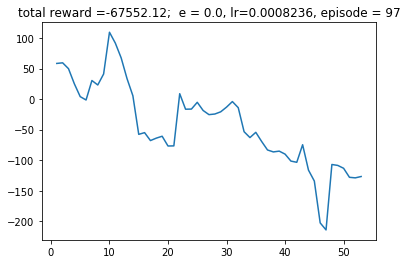

Waiting to train the whole dataset
action0:  121 
action1:  532 
action2:  1297
DONE, lets roll!!
358.04
More than 80 on candle 1804


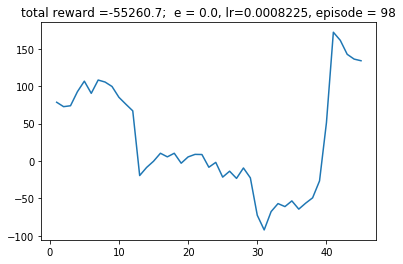

Waiting to train the whole dataset
action0:  100 
action1:  641 
action2:  1209
DONE, lets roll!!
354.109
More than 80 on candle 1802


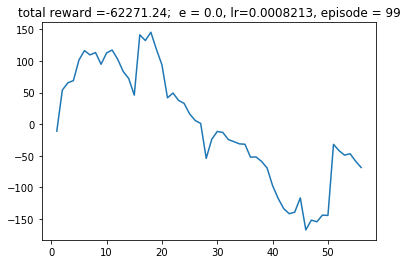

Waiting to train the whole dataset
action0:  114 
action1:  484 
action2:  1352
DONE, lets roll!!
358.034
More than 80 on candle 1792


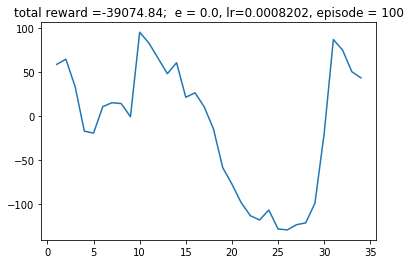

Waiting to train the whole dataset
action0:  64 
action1:  495 
action2:  1391
DONE, lets roll!!
350.488
More than 80 on candle 1776


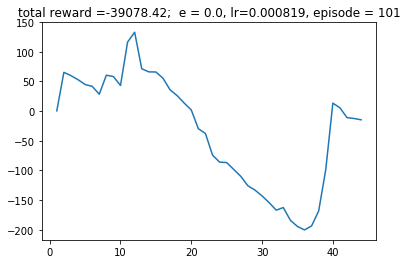

Waiting to train the whole dataset
action0:  57 
action1:  644 
action2:  1249
DONE, lets roll!!
359.029
More than 80 on candle 1791


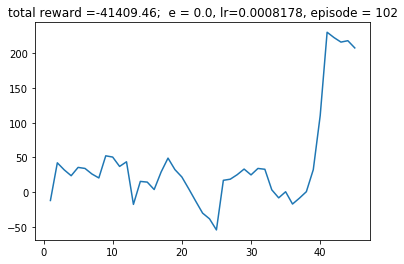

Waiting to train the whole dataset
action0:  76 
action1:  746 
action2:  1128
DONE, lets roll!!
354.036
More than 80 on candle 1787


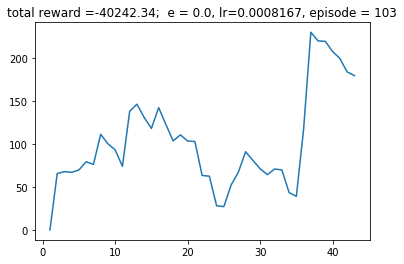

Waiting to train the whole dataset
action0:  66 
action1:  614 
action2:  1270
DONE, lets roll!!
352.357
More than 80 on candle 1781


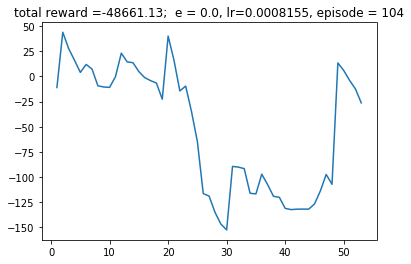

Waiting to train the whole dataset
action0:  77 
action1:  698 
action2:  1175
DONE, lets roll!!
359.008
More than 80 on candle 1794


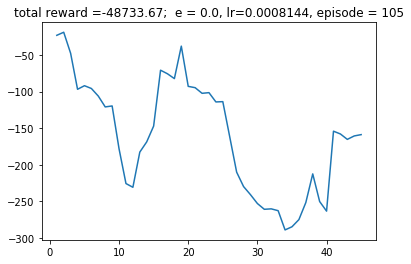

Waiting to train the whole dataset
action0:  80 
action1:  568 
action2:  1302
DONE, lets roll!!
354.335
More than 80 on candle 1860


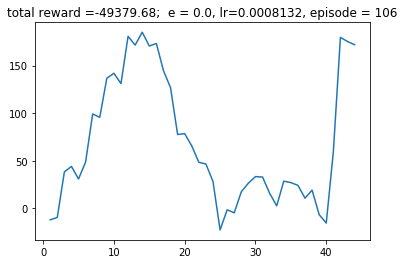

Waiting to train the whole dataset
action0:  89 
action1:  662 
action2:  1199
DONE, lets roll!!
356.538
More than 80 on candle 882
More than 80 on candle 1745


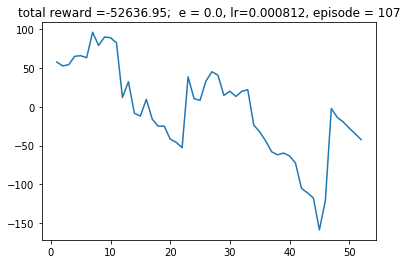

Waiting to train the whole dataset
action0:  102 
action1:  572 
action2:  1276
DONE, lets roll!!
368.34
More than 80 on candle 1805


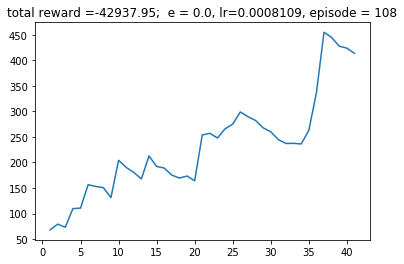

Waiting to train the whole dataset
action0:  86 
action1:  588 
action2:  1276
DONE, lets roll!!
363.499
More than 80 on candle 1883


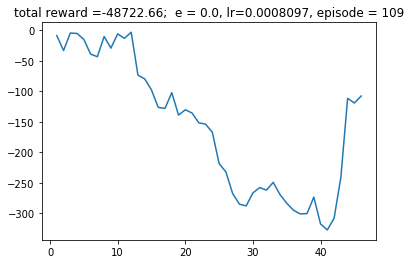

Waiting to train the whole dataset
action0:  79 
action1:  518 
action2:  1353
DONE, lets roll!!
356.469
More than 80 on candle 1771


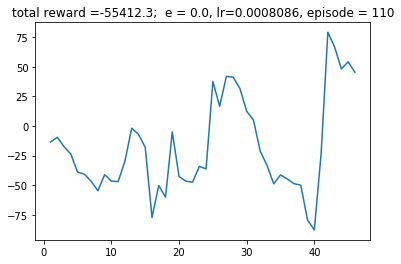

Waiting to train the whole dataset
action0:  102 
action1:  732 
action2:  1116
DONE, lets roll!!
353.317
More than 80 on candle 1844


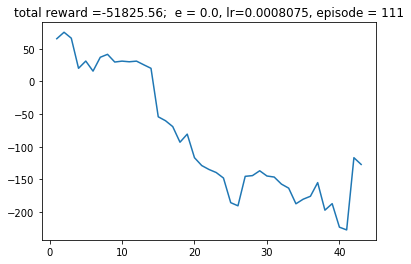

Waiting to train the whole dataset
action0:  84 
action1:  503 
action2:  1363
DONE, lets roll!!
360.257
More than 80 on candle 1837


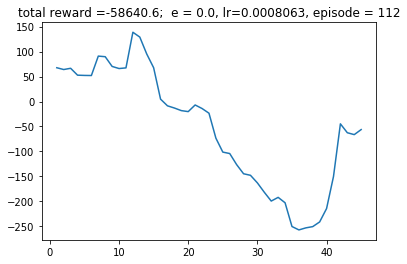

Waiting to train the whole dataset
action0:  103 
action1:  671 
action2:  1176
DONE, lets roll!!
357.623


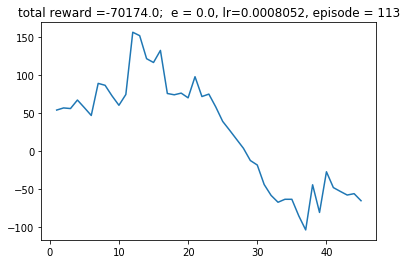

Waiting to train the whole dataset
action0:  121 
action1:  761 
action2:  1068
DONE, lets roll!!
354.539
More than 80 on candle 1864


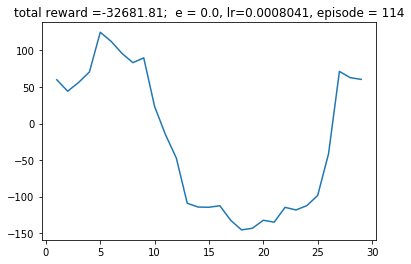

Waiting to train the whole dataset
action0:  29 
action1:  649 
action2:  1272
DONE, lets roll!!
355.953
More than 80 on candle 1806


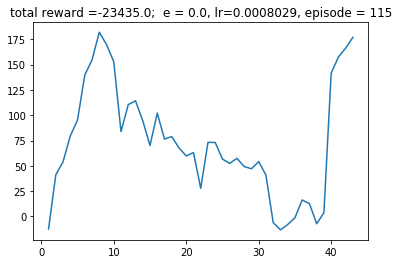

Waiting to train the whole dataset
action0:  28 
action1:  714 
action2:  1208
DONE, lets roll!!
358.395


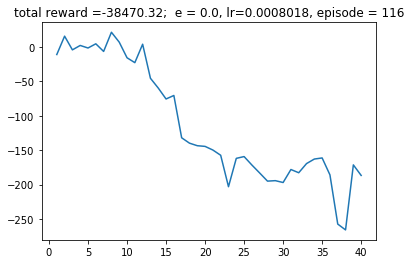

Waiting to train the whole dataset
action0:  47 
action1:  688 
action2:  1215
DONE, lets roll!!
358.05
More than 80 on candle 1876


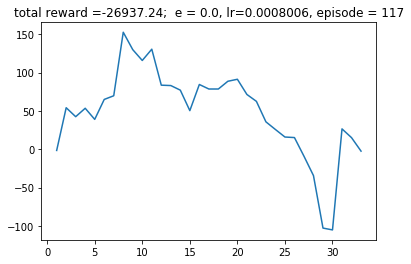

Waiting to train the whole dataset
action0:  22 
action1:  546 
action2:  1382
DONE, lets roll!!
355.134
More than 80 on candle 1809


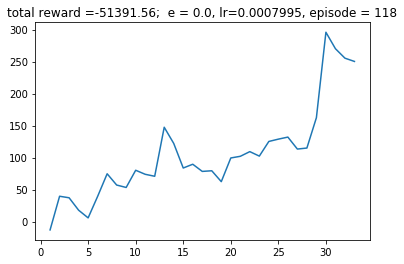

Waiting to train the whole dataset
action0:  98 
action1:  574 
action2:  1278
DONE, lets roll!!
357.613
More than 80 on candle 1794


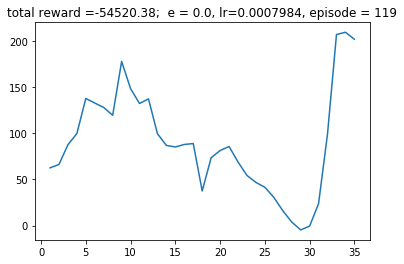

Waiting to train the whole dataset
action0:  100 
action1:  571 
action2:  1279
DONE, lets roll!!
355.804
More than 80 on candle 1788


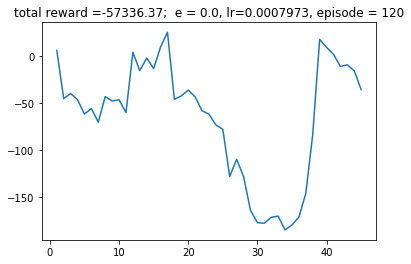

Waiting to train the whole dataset
action0:  98 
action1:  757 
action2:  1095
DONE, lets roll!!
359.286
More than 80 on candle 1783


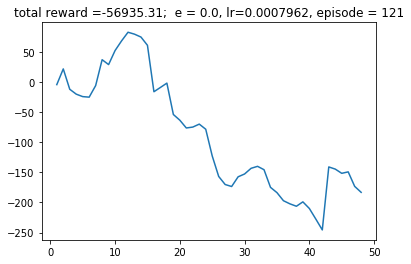

Waiting to train the whole dataset
action0:  98 
action1:  564 
action2:  1288
DONE, lets roll!!
349.32
More than 80 on candle 1807


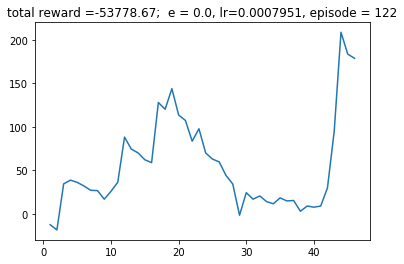

Waiting to train the whole dataset
action0:  93 
action1:  538 
action2:  1319
DONE, lets roll!!
357.52
More than 80 on candle 116
More than 80 on candle 495
More than 80 on candle 1784


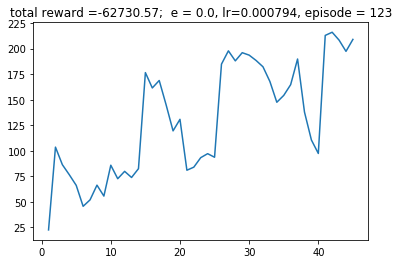

Waiting to train the whole dataset
action0:  125 
action1:  547 
action2:  1278
DONE, lets roll!!
359.487
More than 80 on candle 542
More than 80 on candle 1788


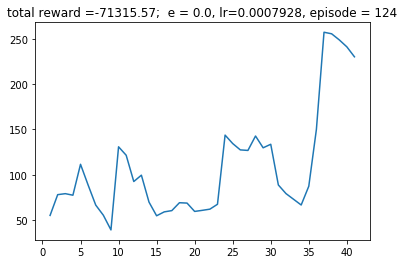

Waiting to train the whole dataset
action0:  143 
action1:  475 
action2:  1332
DONE, lets roll!!
361.873
More than 80 on candle 1795


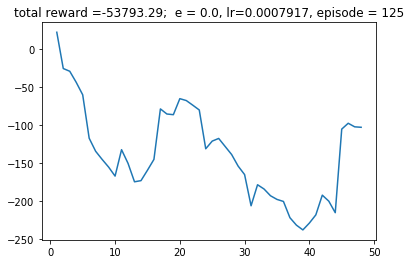

Waiting to train the whole dataset
action0:  87 
action1:  696 
action2:  1167
DONE, lets roll!!
361.067
More than 80 on candle 1835


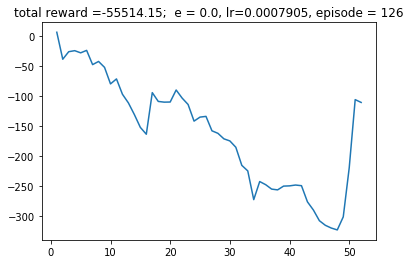

Waiting to train the whole dataset
action0:  97 
action1:  724 
action2:  1129
DONE, lets roll!!
360.989
More than 80 on candle 1889


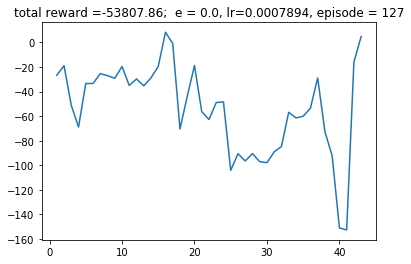

Waiting to train the whole dataset
action0:  97 
action1:  743 
action2:  1110
DONE, lets roll!!
355.885
More than 80 on candle 1789


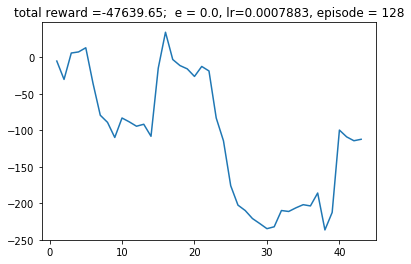

Waiting to train the whole dataset
action0:  76 
action1:  677 
action2:  1197
DONE, lets roll!!
360.671
More than 80 on candle 1794


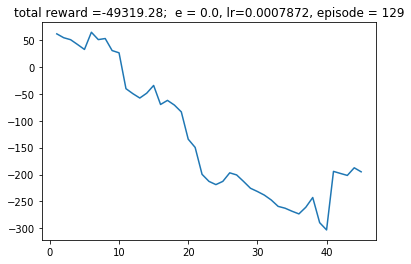

Waiting to train the whole dataset
action0:  75 
action1:  505 
action2:  1370
DONE, lets roll!!
356.015
More than 80 on candle 1816


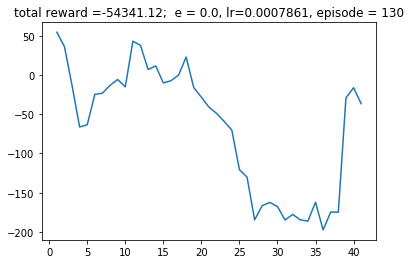

Waiting to train the whole dataset
action0:  98 
action1:  481 
action2:  1371
DONE, lets roll!!
359.944
More than 80 on candle 1792


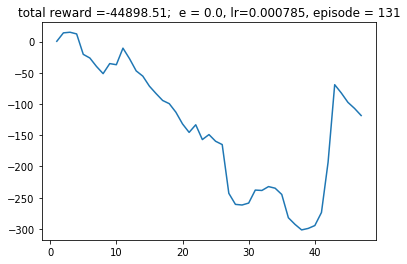

Waiting to train the whole dataset
action0:  66 
action1:  660 
action2:  1224
DONE, lets roll!!
357.314
More than 80 on candle 1839


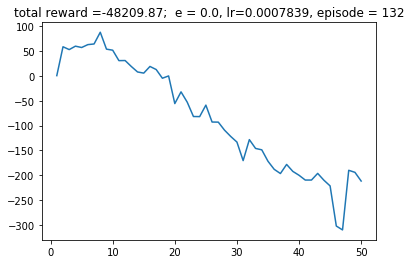

Waiting to train the whole dataset
action0:  74 
action1:  604 
action2:  1272
DONE, lets roll!!
356.751
More than 80 on candle 543


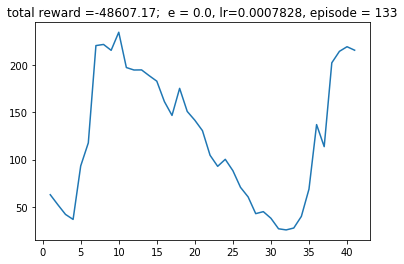

Waiting to train the whole dataset
action0:  82 
action1:  675 
action2:  1193
DONE, lets roll!!
358.652
More than 80 on candle 509
More than 80 on candle 1807


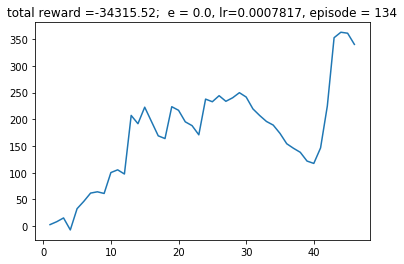

Waiting to train the whole dataset
action0:  59 
action1:  765 
action2:  1126
DONE, lets roll!!
359.124
More than 80 on candle 1797


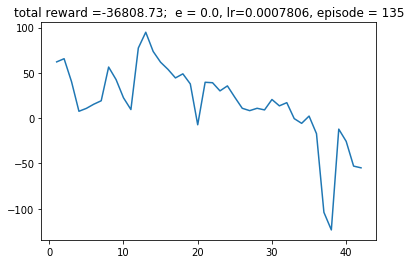

Waiting to train the whole dataset
action0:  49 
action1:  553 
action2:  1348
DONE, lets roll!!
351.218
More than 80 on candle 1804


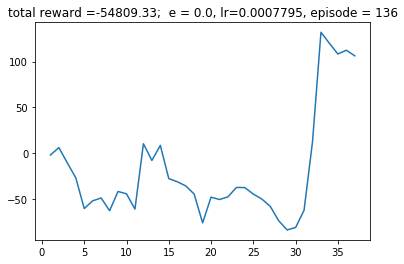

Waiting to train the whole dataset
action0:  91 
action1:  549 
action2:  1310
DONE, lets roll!!
351.822
More than 80 on candle 1836


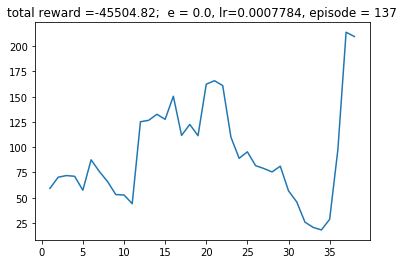

Waiting to train the whole dataset
action0:  74 
action1:  435 
action2:  1441
DONE, lets roll!!
359.124
More than 80 on candle 545
More than 80 on candle 1750


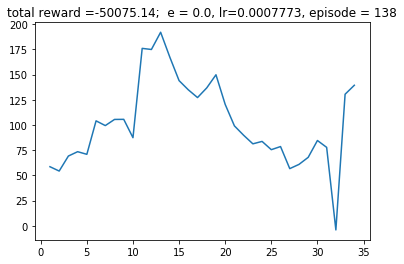

Waiting to train the whole dataset
action0:  89 
action1:  524 
action2:  1337
DONE, lets roll!!
364.335
More than 80 on candle 496
More than 80 on candle 1790


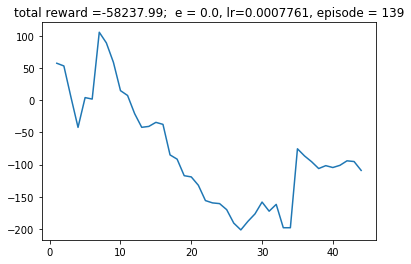

Waiting to train the whole dataset
action0:  110 
action1:  486 
action2:  1354
DONE, lets roll!!
366.045
More than 80 on candle 1803


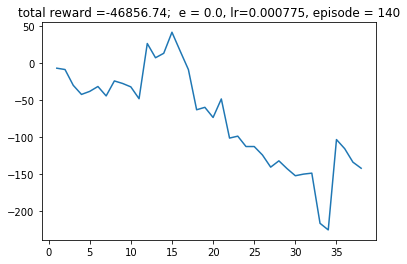

Waiting to train the whole dataset
action0:  70 
action1:  691 
action2:  1189
DONE, lets roll!!
359.219
More than 80 on candle 1796


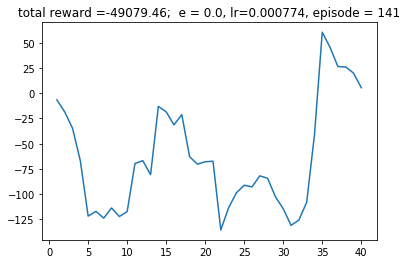

Waiting to train the whole dataset
action0:  78 
action1:  548 
action2:  1324
DONE, lets roll!!
362.085
More than 80 on candle 1842


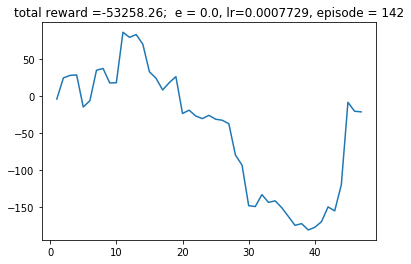

Waiting to train the whole dataset
action0:  92 
action1:  590 
action2:  1268
DONE, lets roll!!
355.939


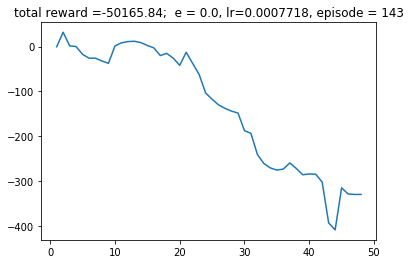

Waiting to train the whole dataset
action0:  72 
action1:  581 
action2:  1297
DONE, lets roll!!
352.19
More than 80 on candle 1895


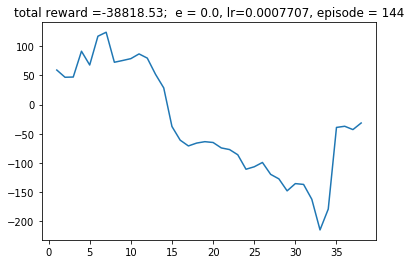

Waiting to train the whole dataset
action0:  47 
action1:  588 
action2:  1315
DONE, lets roll!!
353.093
More than 80 on candle 1811


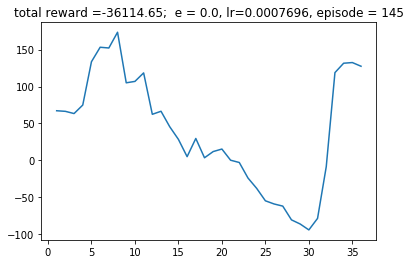

Waiting to train the whole dataset
action0:  57 
action1:  670 
action2:  1223
DONE, lets roll!!
352.219
More than 80 on candle 1807


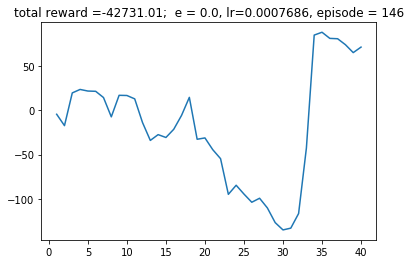

Waiting to train the whole dataset
action0:  66 
action1:  692 
action2:  1192
DONE, lets roll!!
353.502
More than 80 on candle 1874


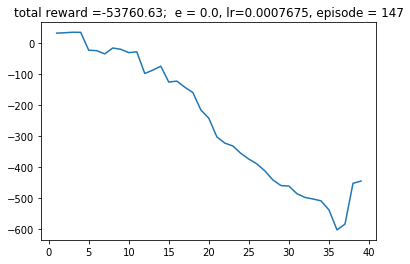

Waiting to train the whole dataset
action0:  84 
action1:  489 
action2:  1377
DONE, lets roll!!
358.106
More than 80 on candle 545
More than 80 on candle 1792


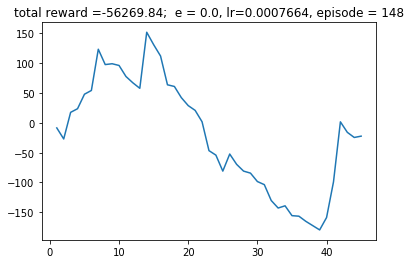

Waiting to train the whole dataset
action0:  101 
action1:  662 
action2:  1187
DONE, lets roll!!
353.069
More than 80 on candle 1836


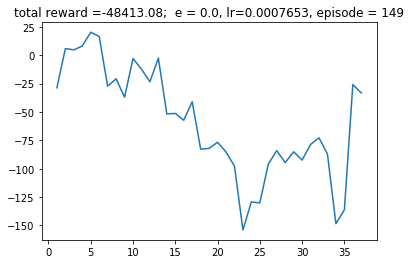

Waiting to train the whole dataset
action0:  76 
action1:  639 
action2:  1235
DONE, lets roll!!
357.366
More than 80 on candle 1800


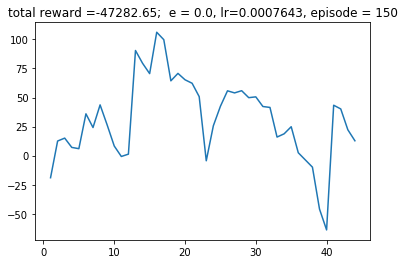

Waiting to train the whole dataset
action0:  75 
action1:  583 
action2:  1292
DONE, lets roll!!
363.162
More than 80 on candle 1811


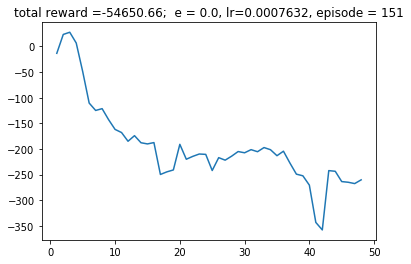

Waiting to train the whole dataset
action0:  74 
action1:  692 
action2:  1184
DONE, lets roll!!
350.283
More than 80 on candle 1812


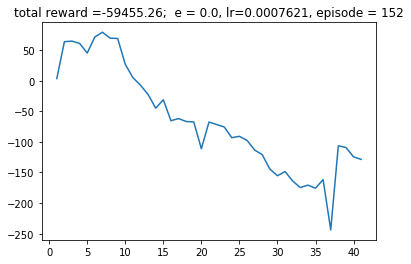

Waiting to train the whole dataset
action0:  102 
action1:  511 
action2:  1337
DONE, lets roll!!
364.492
More than 80 on candle 1802


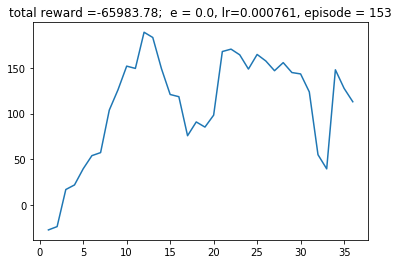

Waiting to train the whole dataset
action0:  110 
action1:  681 
action2:  1159
DONE, lets roll!!
361.468
More than 80 on candle 509
More than 80 on candle 1765


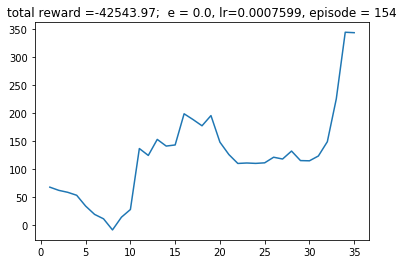

Waiting to train the whole dataset
action0:  77 
action1:  704 
action2:  1169
DONE, lets roll!!
360.524
More than 80 on candle 1878


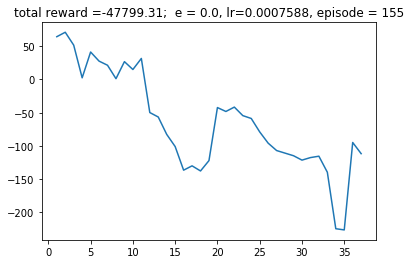

Waiting to train the whole dataset
action0:  77 
action1:  578 
action2:  1295
DONE, lets roll!!
358.867
More than 80 on candle 1806


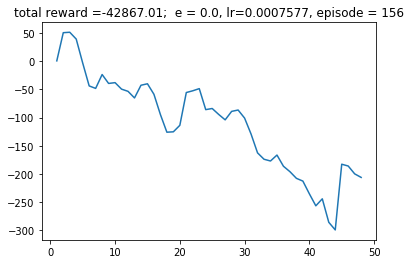

Waiting to train the whole dataset
action0:  61 
action1:  507 
action2:  1382
DONE, lets roll!!
359.211


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 128 #32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    akce0 = 0
    akce1 = 0
    akce2 = 0
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        if action == 0:
            akce0 += 1
        if action == 1:
            akce1 += 1
        if action == 2:
            akce2 += 1
        
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(4)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    print("action0: ", akce0,"\naction1: ", akce1,"\naction2: ", akce2)
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))